In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np

import random
import h5py
from keras.datasets import cifar10
from keras.models import *
from keras.layers import *
from keras.layers.core import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
from keras.regularizers import *
import theano.tensor as T
import theano
from theano.tensor.shared_randomstreams import RandomStreams
from sklearn import metrics
from skimage.measure import compare_ssim
from scipy.misc import toimage
from sklearn.preprocessing import *

import os
import random
import time
from skimage import io, exposure, feature, color, transform
import matplotlib
import matplotlib.pyplot as plt
import glob

import scipy.signal as sig
import operator
import math

# for reproducibility
np.random.seed(1337) 
random.seed(1337)

Using Theano backend.
Using gpu device 1: GeForce GTX 690 (CNMeM is disabled, cuDNN 5105)


In [2]:
# parameters for sliding window, and window function (Hann)
STEP_SIZE = 480
OVERLAP_SIZE = 32
WINDOW_SIZE = STEP_SIZE + OVERLAP_SIZE
OVERLAP_FUNC = sig.hann(OVERLAP_SIZE * 2)

# directory that contains TIMIT files
TIMIT_DIR = "/home/sri/Desktop/timit"

# directory that contains .wav files to process
NUM_EPOCHS = 1
BATCH_SIZE = 64

# randomly shuffle data before partitioning into training/validation?
RANDOM_SHUFFLE = True

# sample rate of input file (used in MFCC calculation)
SAMPLE_RATE = 16000

In [3]:
from load_TIMIT import *
from windowingFunctions import *
from utility import *

In [4]:
# read in 100 WAVs from TIMIT training set
rawWaveforms = load_TIMIT_train(TIMIT_DIR, 1000)

Reading in .wav files...


In [5]:
# waveform preprocessing
def preprocessWaveform(waveform):   
    return waveform, ()
   
def unpreprocessWaveform(waveform, params):
    return waveform



# window preprocessing
def preprocessWindows(windows):
    # scale window between -1 and 1
    processed = np.copy(windows)
   
    mn = np.min(processed, axis = 1)
    mx = np.max(processed, axis = 1)

    maxabs = np.maximum(np.abs(mn), np.abs(mx))

    for i in xrange(0, processed.shape[0]):
        processed[i] /= maxabs[i]
    #processed *= 0.98
   
    #processed = (processed + 1.0) / 2.0
   
    return processed, (maxabs,)

def unpreprocessWindows(windows, params):
    # scale window from [-1, 1] to [-32768, 32768]
    scl = params[0]
   
    unprocessed = np.copy(windows)
    #unprocessed /= 0.98
   
    #nprocessed = (unprocessed * 2.0) - 1.0
   
    for i in xrange(0, unprocessed.shape[0]):
        unprocessed[i] *= scl[i]

    return unprocessed

In [6]:
# waveform preprocessing
processedWaveforms = np.copy(rawWaveforms)

# we maximize the volume of every waveform
for i in xrange(0, len(processedWaveforms)):
    processedWaveforms[i], _ = preprocessWaveform(processedWaveforms[i])

In [7]:
# extract windows
rawWindows = extractWindowsMultiple(processedWaveforms, STEP_SIZE, OVERLAP_SIZE,
                                    collapse = True)

# randomly shuffle data
if (RANDOM_SHUFFLE):
    rawWindows = np.random.permutation(rawWindows)

print "Raw windows shape: ", rawWindows.shape
print "Max: ", np.amax(rawWindows)
print "Min: ", np.amin(rawWindows)

Raw windows shape:  (101135, 512)
Max:  17885.0
Min:  -17139.0


In [8]:
# data augmentation goes here, at some point
augWindows = np.copy(rawWindows)

print "Aug windows shape: ", augWindows.shape

Aug windows shape:  (101135, 512)


In [9]:
processedWindows, pwParams = preprocessWindows(augWindows)

In [10]:
# reshape into vector form
processedWindows = np.reshape(processedWindows, (processedWindows.shape[0], WINDOW_SIZE, 1))

In [11]:
print processedWindows.shape

print np.mean(processedWindows, axis=None)
print np.std(processedWindows, axis=None)
print np.min(processedWindows, axis = None)
print np.max(processedWindows, axis = None)

(101135, 512, 1)
0.0179514
0.286117
-1.0
1.0


In [12]:
class Binarize(T.Op):
    # properties attribute
    __props__ = ()
    
    def __init__(self):
        super(Binarize, self).__init__()
        
    def make_node(self, x):
        assert hasattr(self, '_props'), "Your version of theano is too old to support __props__."
        x = T.as_tensor_variable(x)
        return theano.Apply(self, [x], [x.type()])
    
    def perform(self, node, inputs, output_storage):
        x, = inputs
        z, = output_storage
        
        # TODO: learn threshold per parameter?
        z[0] = np.copy(x)
        z[0][z[0] < 0] = -1
        z[0][z[0] >= 0] = 1
    
    def grad(self, input, output_gradients):
        # pass through gradients unchanged
        # (i don't think there's a mathematical justification for this?)
        g = output_gradients[0]
        
        return [g]
        
    def infer_shape(self, node, i0_shapes):
        # output shape is same as input shape
        return i0_shapes



In [13]:
class StochasticBinarize(T.Op):
    # properties attribute
    __props__ = ()
    
    def __init__(self):
        super(StochasticBinarize, self).__init__()
        
    def make_node(self, x):
        assert hasattr(self, '_props'), "Your version of theano is too old to support __props__."
        x = T.as_tensor_variable(x)
        return theano.Apply(self, [x], [x.type()])
    
    def perform(self, node, inputs, output_storage):
        x, = inputs
        z, = output_storage
        
        prob_thresh = (x + 1.0) / 2.0
        probs = np.random.random_sample(x.shape)
        res = np.greater(probs, prob_thresh)
        res = res.astype('float32') * 2.0 - 1.0
        res = -res
        
        # TODO: learn threshold per parameter?
        z[0] = np.copy(res)
    
    def grad(self, input, output_gradients):
        # pass through gradients unchanged (since expected value
        # is just x)
        return [output_gradients[0]]
        
    def infer_shape(self, node, i0_shapes):
        # output shape is same as input shape
        return i0_shapes

In [14]:
class QuantizeProbabilities(T.Op):
    # properties attribute
    __props__ = ()
    
    def __init__(self, num_bins):
        super(QuantizeProbabilities, self).__init__()
        self.num_bins = num_bins
        
    def make_node(self, x):
        assert hasattr(self, '_props'), "Your version of theano is too old to support __props__."
        x = T.as_tensor_variable(x)
        return theano.Apply(self, [x], [x.type()])
    
    def perform(self, node, inputs, output_storage):
        x, = inputs
        z, = output_storage
        
        # TODO: learn threshold per parameter?
        z[0] = np.round(x * (self.num_bins - 1)) / float(self.num_bins - 1)
    
    def grad(self, input, output_gradients):
        # pass through gradients unchanged
        #     "straight-through" estimator
        g = output_gradients[0]
        
        return [g]
        
    def infer_shape(self, node, i0_shapes):
        # output shape is same as input shape
        return i0_shapes

In [15]:
class OneHotArgmax(T.Op):
    # properties attribute
    __props__ = ()
    
    def __init__(self, n):
        super(OneHotArgmax, self).__init__()
        
    def make_node(self, x):
        assert hasattr(self, '_props'), "Your version of theano is too old to support __props__."
        x = T.as_tensor_variable(x)
        return theano.Apply(self, [x], [x.type()])
    
    def perform(self, node, inputs, output_storage):
        x, = inputs
        z, = output_storage
        
        m = np.repeat(np.max(x, axis = 2).reshape(x.shape[0], x.shape[1], 1), x.shape[2], axis = 2)
        one = x - m
        one[one >= 0] = 1
        one[one < 0] = 0
        z[0] = one
    
    def grad(self, input, output_gradients):
        # pass through gradients unchanged
        g = output_gradients[0]
        
        return [g]
        
    def infer_shape(self, node, i0_shapes):
        # output shape is same as input shape
        return i0_shapes

In [16]:
class PhaseShift1D(Layer):
    """ PhaseShift1D
    Takes vector of size: B x S x nF
    And returns vector: B x nS x F
    """
    def __init__(self, n, **kwargs):
        super(PhaseShift1D, self).__init__(**kwargs)
        self.n = n
    
    def build(self, input_shape):
        # no trainable parameters
        self.trainable_weights = []
    
    def call(self, x, mask=None):
        r = T.reshape(x, (x.shape[0], x.shape[1], x.shape[2] / self.n, self.n))
        r = T.transpose(r, (0, 1, 3, 2))
        r = T.reshape(r, (x.shape[0], x.shape[1] * self.n, x.shape[2] / self.n))
        return r

    def get_output_shape_for(self, input_shape):
        return (input_shape[0], input_shape[1] * self.n, input_shape[2] / self.n)
    
    def get_config(self):
        config = {'n' : self.n}
        base_config = super(PhaseShift1D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [172]:
class UniformNoise(Layer):
    def __init__(self, scale, **kwargs):
        self.supports_masking = True
        self.scale = scale
        self.uses_learning_phase = True
        super(UniformNoise, self).__init__(**kwargs)

    def call(self, x, mask=None):
        noise_x = x + K.random_uniform(shape = K.shape(x),
                                       low = -self.scale,
                                       high = self.scale)
        return K.in_train_phase(noise_x, x)

    def get_config(self):
        config = {'scale': self.scale}
        base_config = super(UniformNoise, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [286]:
from keras.activations import softmax, sigmoid

# lambda to compute MSE between 2 vectors
def mse_lambda(vects):
    x, y = vects
    return K.mean(K.square(x - y))

# freeze weights for stacked training
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

# we generate a new optimizer of the same kind for every model
# we train
def opti():
    return Adam()

input_dim = (WINDOW_SIZE, 1)
input_size = np.prod(input_dim)
bottleneck_size = 128
num_cats = 2

# softmax "upsampling" initialization
# identity matrix repeated, plus uniform noise
def categorical_upsampling(input_dim, var_dim):
    def init(shape, name = None):
        assert(shape[-1] == input_dim * var_dim)
        
        random_additive = np.random.uniform(-0.1, 0.1, shape)
        ident = np.eye(input_dim).repeat(var_dim, axis = 1)
        random_multiplicative = np.random.normal(1.0, 0.1, shape)
        
        return K.variable(ident * random_multiplicative + random_additive)
    
    return init






# Gumbel-Max sampling 
tau = K.variable(2.0, name="temperature")
anneal_rate = 0.01
min_temperature = 0.1

'''
def sampling(logits_y):
    u = K.random_uniform(K.shape(logits_y), 0, 1)
    gumbel_noise = -K.log(-K.log(u + 1e-20) + 1e-20)

    probs = K.sigmoid((gumbel_noise + logits_y) / tau)
    return probs
'''

#discrete_values = K.variable([0.0, 1.0])
def sampling(logits_y):
    # gumbel noise
    #u = K.random_uniform(K.shape(logits_y), 0, 1)
    #gumbel_noise = -K.log(-K.log(u + 1e-20) + 1e-20)
    
    # calculate softmax probabilities and retrieve expected value
    final_probs = softmax(K.reshape(logits_y, (-1, bottleneck_size, num_cats)) / tau)
    
    return final_probs
    
    # final output is expected value
    #expected = T.dot(final_probs, discrete_values)
    #return expected



def encoder_residual_block(output_dim = 64, filt_size = 5, subsample = True):
    def f(input):
        stride = 1
        #if (subsample):
        #    stride = 2
        
        conv1 = Convolution1D(output_dim, filt_size, border_mode = 'same',
                          init = 'he_uniform', activation = 'linear',
                          subsample_length = stride, bias = True)(input)
        if (subsample):
            conv1 = MaxPooling1D(2)(conv1)
        #conv1 = SpatialDropout1D(0.1)(conv1)
        act1 = LeakyReLU(0.3)(conv1)
        
        conv2 = Convolution1D(output_dim, filt_size, border_mode = 'same',
                          init = 'he_uniform', activation = 'linear',
                          bias = True)(act1)
        #conv2 = SpatialDropout1D(0.1)(conv2)
        
        residual = conv2
        shortcut = Convolution1D(output_dim, 1, border_mode = 'same',
                                 init = 'he_uniform', activation = 'linear',
                                 subsample_length = stride, bias = True)(input)
        if (subsample):
            shortcut = MaxPooling1D(2)(shortcut)
        
        m = merge([shortcut, residual], mode = 'sum')
        return LeakyReLU(0.3)(m)
    
    return f

def decoder_residual_block(output_dim = 64, filt_size = 5, upsample = True):
    def f(input):
        nfilts = output_dim
        if (upsample):
            nfilts = output_dim * 2

        conv1 = Convolution1D(nfilts, filt_size, border_mode = 'same',
                          init = 'he_uniform', activation = 'linear',
                          bias = True)(input)
        act1 = LeakyReLU(0.3)(conv1)
        
        conv2 = Convolution1D(nfilts, filt_size, border_mode = 'same',
                          init = 'he_uniform', activation = 'linear',
                          bias = True)(act1)
        
        residual = conv2
        shortcut = Convolution1D(nfilts, 1, border_mode = 'same',
                                 init = 'he_uniform', activation = 'linear',
                                 bias = True)(input)
        
        m = merge([shortcut, residual], mode = 'sum')
        r = LeakyReLU(0.3)(m)
        if (upsample):
            return PhaseShift1D(2)(r)
        else:
            return r
    
    return f
#'''

def hard_tanh(x):
    return K.clip(x, -1.0, 1.0)

# ---------------------------------------------------------------------------
# autoencoder: takes an audio window, compresses it, and tries to reconstruct it
# ---------------------------------------------------------------------------
def autoencoder_structure(dim):
    enc_input = Input(shape = dim)
    
    # corrupt input slightly as a form of regularization
    #enc = GaussianDropout(0.05, input_shape = dim)(enc_input)

    # (512x1) => (512x48)
    #enc = encoder_residual_block(48, 9, False)(enc_input)

    # (512x48) => (256x48)
    enc = encoder_residual_block(96, 5, True)(enc_input)
    
    # (256x48) => (256x48)
    enc = encoder_residual_block(96, 5, False)(enc)

    # (256x48) => (128x48)
    enc = encoder_residual_block(96, 5, True)(enc)
    
    # (128x48) => (128x48)
    enc = encoder_residual_block(96, 5, False)(enc)

    # (128x48) => (128)
    enc = Convolution1D(1, 9, border_mode = 'same',
                              init = 'he_uniform', activation = 'tanh',#'linear',
                              bias = True)(enc)
    #enc = LeakyReLU(0.3)(enc)
    enc = Reshape((bottleneck_size,))(enc)
    #enc = Dense(bottleneck_size, activation = 'sigmoid', init = 'identity')(enc)
    #enc = Dense(bottleneck_size * num_cats,
    #            init = categorical_upsampling(bottleneck_size, num_cats),
    #            activation = 'linear')(enc)
    #enc = (Lambda(sampling, output_shape=(bottleneck_size, num_cats)))(enc)
    #enc = UniformNoise(1.0 / 32.0)(enc)
    
    enc = Model(input = enc_input, output = enc)
    
    
    
    
    #dec_input = Input(shape = (bottleneck_size, num_cats))
    dec_input = Input(shape = (bottleneck_size,))
    dec = Reshape((128, 1,))(dec_input)
    #dec = UniformNoise(1.0 / 32.0)(dec)
    
    #dec = Convolution1D(1, 1, border_mode = 'same',
    #                          init = 'he_uniform', activation = 'linear',
    #                          bias = True)(dec_input)
    
    #dec = Reshape((128,))(dec)
    #dec = Dense(bottleneck_size, activation = 'linear', init = 'identity')(dec_input)
    #dec = LeakyReLU(0.3)(dec)
    #dec = Reshape((128, 1,))(dec)
    
    # (64x1) => (64x48)
    dec = decoder_residual_block(96, 5, False)(dec)
    
    # (64x48) => (128x48)
    dec = decoder_residual_block(64, 5, True)(dec)
    
    # (128x48) => (128x48)
    dec = decoder_residual_block(96, 5, False)(dec)
    
    # (128x48) => (256x48)
    dec = decoder_residual_block(64, 5, True)(dec)
    
    # (256x48) => (256x48)
    #dec = decoder_residual_block(48, 9, False)(dec)

    # (512x48) => (512x1)
    dec = Convolution1D(1, 9, border_mode = 'same',
                              init = 'he_uniform', activation = 'tanh',
                              bias = True)(dec)
    #dec = LeakyReLU(0.3)(dec)
    
    #dec = Reshape((WINDOW_SIZE,))(dec)
    #dec = Dense(WINDOW_SIZE, activation = 'tanh', init = 'identity')(dec)
    #dec = Reshape((WINDOW_SIZE, 1,))(dec)
    
    dec = Model(input = dec_input, output = dec)
    
    return enc, dec

# ---------------------------------------------------------------------------
# discriminator: tries to differentiate between original and reconstructed samples
# ---------------------------------------------------------------------------
def discriminator_structure(dim):
    dsc = Sequential()
    
    dsc.add(Convolution1D(48, 5, border_mode='same', input_shape = dim,
                                    init = 'uniform',
                                    subsample_length = 2, activation = 'linear'))
    dsc.add(LeakyReLU(0.3))
    
    dsc.add(Convolution1D(48, 5, border_mode='same', input_shape = dim,
                                    init = 'uniform',
                                    activation = 'linear'))
    dsc.add(LeakyReLU(0.3))

    dsc.add(Convolution1D(48, 5, border_mode='valid', input_shape = dim,
                                    init = 'uniform',
                                    subsample_length = 2, activation = 'linear'))
    dsc.add(LeakyReLU(0.3))
    
    dsc.add(Convolution1D(48, 5, border_mode='same', input_shape = dim,
                                    init = 'uniform',
                                    activation = 'linear'))
    dsc.add(LeakyReLU(0.3))
    
    dsc.add(Convolution1D(48, 5, border_mode='valid', input_shape = dim,
                                    init = 'uniform',
                                    subsample_length = 2, activation = 'linear'))
    dsc.add(LeakyReLU(0.3))
    
    dsc.add(Flatten())
    
    dsc.add(Dense(64, activation = 'linear'))
    dsc.add(LeakyReLU(0.3))
    dsc.add(Dense(1, activation = 'sigmoid'))
    
    return dsc


# construct autoencoder to be used in adversarial training (AAC - Adversarial AutoenCoder)
# uhhhh... whoops i screwed up the acronym
aac_input = Input(shape = input_dim)
aac_enc, aac_dec = autoencoder_structure(input_dim)
aac_embedding = aac_enc(aac_input)
#aac_embedding_quant = Lambda(lambda x : QuantizeProbabilities(4)(x))(aac_embedding)
aac_reconstructed = aac_dec(aac_embedding)

aac_autoencoder = Model(input = [aac_input], output = [aac_reconstructed])
aac_autoencoder.compile(loss = 'mean_squared_error', optimizer = opti())



# construct discriminator: regular
regdsc_input_dim = (WINDOW_SIZE, 1)
regdsc_input = Input(shape = input_dim)
regdsc_struct = discriminator_structure(regdsc_input_dim)

regdsc_label = regdsc_struct(regdsc_input)
aac_reg_label = regdsc_struct(aac_reconstructed)



def prob_quantization_loss(placeholder, code):
    loss = K.minimum(code, 1.0 - code)
    loss_weight = 10.0

    return K.switch(tau < 0.25, loss * loss_weight, \
                                K.zeros_like(code))


def code_variance(placeholder, code):
    #noise = K.random_uniform(K.shape(code), -(1.0 / 32.0), (1.0 / 32.0))
    #return K.var(code + noise, axis = -1)
    return K.mean(K.abs(code), axis = -1)



# compile model
loss_weights = [350.0, 1.0, 2.5]
n_discrim = 1
n_code = 1
lmult = len(loss_weights) - n_discrim - n_code


make_trainable(aac_autoencoder, False)

aac_discrim_reg = Model(input = [regdsc_input], output = [regdsc_label])
aac_discrim_reg.compile(loss = ['binary_crossentropy'], optimizer = opti())
aac_discrim_reg.summary()

aac_autoencoder.summary()

make_trainable(aac_discrim_reg, False)
make_trainable(aac_autoencoder, True)
model = Model(input = [aac_input], output = [aac_reconstructed] * lmult + \
                                            [aac_reg_label] + \
                                            [aac_embedding] * n_code)
model.compile(loss = ['mean_squared_error', \
                      'binary_crossentropy', \
                      code_variance],#  prob_quantization_loss],
              loss_weights = loss_weights,
              optimizer = opti())
model.summary()

X_train = np.copy(processedWindows)
ntrain = X_train.shape[0]



____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_76 (InputLayer)            (None, 512, 1)        0                                            
____________________________________________________________________________________________________
sequential_19 (Sequential)       (None, 1)             234081      input_76[0][0]                   
Total params: 234081
____________________________________________________________________________________________________
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_73 (InputLayer)            (None, 512, 1)        0                                            
______________________________________________________________________

In [287]:
def test_discriminator(discriminator, autoencoder, X, y, verbose = True):
    # verify discriminator was trained properly
    y_hat = discriminator.predict(X)
    y_hat[y_hat >= 0.5] = 1
    y_hat[y_hat < 0.5] = 0

    n_total = y.shape[0]
    n_correct = np.sum(np.ravel(y_hat) == y)

    acc = n_correct * 100.0 / n_total
    if (verbose):
        print "Discriminator accuracy: %0.02f pct (%d of %d) right"%(acc, n_correct, n_total)
    return acc

In [288]:
def autoencoderTest(waveFilename, prefix, autoencoder, verbose = True):
    [rate, data] = sciwav.read(waveFilename)
    processedWave, wparams = preprocessWaveform(data)
    windows = extractWindows(processedWave, STEP_SIZE, OVERLAP_SIZE)
    

    # first, write desired reconstruction
    transformed, tparams = preprocessWindows(windows)
    if (verbose):
        print transformed.shape
    
    desired = unpreprocessWindows(transformed, tparams)
    desired = reconstructFromWindows(desired, OVERLAP_SIZE, OVERLAP_FUNC)
    desired = unpreprocessWaveform(desired, wparams)
    #sciwav.write(prefix + "_res_desired.wav", rate, desired.astype(np.int16))
    
    # then, run NN on transformed windows
    transformed, tparams = preprocessWindows(windows)
    
    transformed = np.reshape(transformed, (transformed.shape[0], WINDOW_SIZE, 1))
    autoencOutput = autoencoder.predict(transformed, batch_size = BATCH_SIZE, verbose = (1 if verbose else 0))
    if (verbose):
        print autoencOutput.shape
    autoencOutput = np.reshape(autoencOutput, (autoencOutput.shape[0], WINDOW_SIZE))
    
    if (verbose):
        print autoencOutput.shape
    recons = unpreprocessWindows(autoencOutput, tparams)
    recons = reconstructFromWindows(recons, OVERLAP_SIZE, OVERLAP_FUNC)
    recons = unpreprocessWaveform(recons, wparams)
    
    sciwav.write(prefix + "_output.wav", rate, recons.astype(np.int16))
    
    metrics = [
        np.max(desired),
        np.min(desired),
        np.max(recons),
        np.min(recons),
        mse(recons, desired),
        avgErr(recons, desired)
    ]
    
    if (verbose):
        print "Max/min desired:", metrics[0], metrics[1]
        print "Max/min recons: ", metrics[2], metrics[3]
        print waveFilename, " mse: ", metrics[4]
        print waveFilename, " avg err: ", metrics[5]
        
    return metrics

In [289]:
# interleave two numpy arrays of the same size along the first axis
def interleave(a, b):    
    r = np.empty(a.shape)
    r = np.repeat(r, 2, axis = 0)
    
    r[::2] = a
    r[1::2] = b
    return r

In [290]:
np.set_printoptions(formatter={'float_kind':'{:4f}'.format})

BATCH_SIZE = 128
NUM_BATCHES = ntrain / BATCH_SIZE
NUM_EPOCHS = 10

lead = "    "
d_loss = 0.0
a_losses = []
d_acc = 0.0
discrim_train_y = np.concatenate((np.ones(ntrain), np.zeros(ntrain)))


for epoch in range(NUM_EPOCHS):
    print "Epoch " + str(epoch + 1) + ":"

    # present batches randomly each epoch
    lis = range(0, ntrain, BATCH_SIZE)
    random.shuffle(lis)
    
    # keep track of start time and current batch #
    i = 0
    startTime = time.time()
    for idx in lis:
        batch = X_train[idx:idx+BATCH_SIZE, :,  :]
        nbatch = batch.shape[0]
        
        a_losses = ["autoencoder not training"]
        d_loss = "discriminator not training"
        
        # train autoencoder, if discriminator accuracy is greater than 70%
        if (epoch > 0):
            make_trainable(aac_autoencoder, True)
            make_trainable(aac_discrim_reg, False)
            
            a_y = [batch] * lmult + \
                  [np.ones(nbatch)] * n_discrim + \
                  [np.zeros((nbatch, bottleneck_size))] * n_code
            a_losses = model.train_on_batch(batch, a_y)
        
        # train discriminator(s) on what the autoencoder now generates
        generated = aac_autoencoder.predict(batch)
        discrim_batch_X = interleave(batch, generated)
        discrim_batch_y = interleave(np.ones(nbatch), np.zeros(nbatch))
        
        make_trainable(aac_autoencoder, False)
        make_trainable(aac_discrim_reg, True)
        d_loss = aac_discrim_reg.train_on_batch(discrim_batch_X, discrim_batch_y)
        
        if (epoch == 0 and d_loss < 0.2):
            print ""
            print lead + "Terminating epoch early (don't wanna overfit!)"
            break
        
        # print statistics every 10 batches so we know stuff is still going down
        if (i % 10 == 0):
            printStr = "        \r" + lead + str(i * BATCH_SIZE) + ": " + str(d_loss) + " "
            print printStr,
            
            loss_arr = np.asarray(a_losses)
            print loss_arr,
            
            if (len(loss_arr) > 1):
                for i in xrange(0, len(loss_weights)):
                    loss_arr[i + 1] *= loss_weights[i]
                print loss_arr,
            
            #print K.get_value(tau),
            #K.set_value(tau, np.max([K.get_value(tau) * np.exp(-anneal_rate * (epoch + 1)), min_temperature]))
            #K.set_value(tau, np.min([K.get_value(tau) * (1 + anneal_rate), max_temperature]))
            
        i += 1
    print ""
    
    # print elapsed time for epoch
    elapsed = time.time() - startTime
    print lead + "Total time for epoch: " + str(elapsed) + "s"
    
    
    # ---------------------------------------------------------
    # evaluate discriminator on random samples every epoch
    # ---------------------------------------------------------
    startTime = time.time()
    print lead + "----------------"

    NUM = 200
    rows = np.random.randint(X_train.shape[0], size = NUM)
    generated = aac_autoencoder.predict(X_train[rows, :], verbose = 0)
    d_X = np.concatenate((X_train[rows, :], generated))
    d_y = np.concatenate((np.ones(NUM), np.zeros(NUM)))
    d_acc = test_discriminator(aac_discrim_reg, aac_autoencoder,
                               d_X, d_y, verbose = False)

    print lead + "Evaluated the discriminator: " + str(d_acc) + "% d_acc"
    elapsed = time.time() - startTime
    print lead + "Total time for evaluation: " + str(elapsed) + "s"
    
    
    # ---------------------------------------------------------
    # evaluate autoencoder on real data every epoch
    # ---------------------------------------------------------
    startTime = time.time()
    print lead + "----------------"
    
    print lead + "Evaluating autoencoder..."
    metrics = autoencoderTest("./SA1.WAV", "SA1_res_reg_train_epoch" + str(epoch+1), aac_autoencoder, verbose = False)
    
    print lead + "Max/min desired:", metrics[0], metrics[1]
    print lead + "Max/min recons: ", metrics[2], metrics[3]
    print lead + "MSE:     ", metrics[4]
    print lead + "Avg err: ", metrics[5]
    elapsed = time.time() - startTime
    print lead + "Total time for evaluation: " + str(elapsed) + "s"
    
    print ""

Epoch 1:
    1280: 0.250830620527  ['autoencoder not training'] 
    Terminating epoch early (don't wanna overfit!)

    Total time for epoch: 13.2241749763s
    ----------------
    Evaluated the discriminator: 99.5% d_acc
    Total time for evaluation: 1.24840807915s
    ----------------
    Evaluating autoencoder...
    Max/min desired: 4899.0 -4013.0
    Max/min recons:  0.0014262 -0.00221186
    MSE:      154618.0
    Avg err:  210.222
    Total time for evaluation: 0.234609127045s

Epoch 2:
    1280: 0.472931325436  [8.697842 0.021077 1.263557 0.022981] [8.697842 7.376831 1.263557 0.057453] 
    Total time for epoch: 703.877268076s
    ----------------
    Evaluated the discriminator: 78.75% d_acc
    Total time for evaluation: 0.459809064865s
    ----------------
    Evaluating autoencoder...
    Max/min desired: 4899.0 -4013.0
    Max/min recons:  4291.25 -2666.68
    MSE:      10135.6
    Avg err:  48.1551
    Total time for evaluation: 0.235558986664s

Epoch 3:
    1280: 0.57

KeyboardInterrupt: 

In [291]:
'''decoder_input = Input(shape = (bottleneck_size,))
decoder_reconstructed = aac_dec(decoder_input)
decoder_reg_label = regdsc_struct(decoder_reconstructed)

decoder = Model(input = [decoder_input], output = [decoder_reconstructed, decoder_reg_label])
decoder.compile(loss = ['mean_squared_error', 'binary_crossentropy'],
              loss_weights = [350, 1],
              optimizer = Adam())
decoder.summary()
'''

"decoder_input = Input(shape = (bottleneck_size,))\ndecoder_reconstructed = aac_dec(decoder_input)\ndecoder_reg_label = regdsc_struct(decoder_reconstructed)\n\ndecoder = Model(input = [decoder_input], output = [decoder_reconstructed, decoder_reg_label])\ndecoder.compile(loss = ['mean_squared_error', 'binary_crossentropy'],\n              loss_weights = [350, 1],\n              optimizer = Adam())\ndecoder.summary()\n"

In [292]:
'''
Xc_train = aac_enc.predict(X_train, batch_size = BATCH_SIZE, verbose = 1)
'''

'\nXc_train = aac_enc.predict(X_train, batch_size = BATCH_SIZE, verbose = 1)\n'

In [293]:
'''NUM_EPOCHS = 5

lead = "    "
d_loss = 0.0
a_losses = []
d_acc = 0.0
discrim_train_y = np.concatenate((np.ones(ntrain), np.zeros(ntrain)))

for epoch in range(NUM_EPOCHS):
    print "Epoch " + str(epoch + 1) + ":"

    # present batches randomly each epoch
    lis = range(0, ntrain, BATCH_SIZE)
    random.shuffle(lis)
    
    # keep track of start time and current batch #
    i = 0
    startTime = time.time()
    for idx in lis:
        batch_code = Xc_train[idx:idx+BATCH_SIZE, :]
        batch_recons = X_train[idx:idx+BATCH_SIZE, :, :]
        nbatch = batch_code.shape[0]
        
        a_losses = ["autoencoder not training"]
        d_loss = "discriminator not training"
        
        # train decoder
        make_trainable(aac_autoencoder, True)
        make_trainable(aac_discrim_reg, False)

        a_y = [batch_recons, np.ones(nbatch)]
        a_losses = decoder.train_on_batch(batch_code, a_y)
        
        # train discriminator(s) on what the decoder now generates
        generated = aac_dec.predict(batch_code)
        discrim_batch_X = interleave(batch_recons, generated)
        discrim_batch_y = interleave(np.ones(nbatch), np.zeros(nbatch))
        
        make_trainable(aac_autoencoder, False)
        make_trainable(aac_discrim_reg, True)
        d_loss = aac_discrim_reg.train_on_batch(discrim_batch_X, discrim_batch_y)
        
        # print statistics every 10 batches so we know stuff is still going down
        if (i % 10 == 0):
            printStr = "        \r" + lead + str(i * BATCH_SIZE) + ": " + str(d_loss) + " "
            print printStr,
            
            loss_arr = np.asarray(a_losses)
            print loss_arr,
            
            if (len(loss_arr) > 1):
                for i in xrange(0, len(loss_weights)):
                    loss_arr[i + 1] *= loss_weights[i]
                print loss_arr,
            
        i += 1
    print ""
    
    # print elapsed time for epoch
    elapsed = time.time() - startTime
    print lead + "Total time for epoch: " + str(elapsed) + "s"
    
    
    # ---------------------------------------------------------
    # evaluate discriminator on random samples every epoch
    # ---------------------------------------------------------
    startTime = time.time()
    print lead + "----------------"

    NUM = 200
    rows = np.random.randint(Xc_train.shape[0], size = NUM)
    generated = aac_dec.predict(Xc_train[rows, :], verbose = 0)
    d_X = np.concatenate((X_train[rows, :], generated))
    d_y = np.concatenate((np.ones(NUM), np.zeros(NUM)))
    d_acc = test_discriminator(aac_discrim_reg, aac_autoencoder,
                               d_X, d_y, verbose = False)

    print lead + "Evaluated the discriminator: " + str(d_acc) + "% d_acc"
    elapsed = time.time() - startTime
    print lead + "Total time for evaluation: " + str(elapsed) + "s"
    
    
    # ---------------------------------------------------------
    # evaluate autoencoder on real data every epoch
    # ---------------------------------------------------------
    startTime = time.time()
    print lead + "----------------"
    
    print lead + "Evaluating autoencoder..."
    metrics = autoencoderTest("./SA1.WAV", "SA1_res_dec_train_epoch" + str(epoch+1), aac_autoencoder, verbose = False)
    
    print lead + "Max/min desired:", metrics[0], metrics[1]
    print lead + "Max/min recons: ", metrics[2], metrics[3]
    print lead + "MSE:     ", metrics[4]
    print lead + "Avg err: ", metrics[5]
    elapsed = time.time() - startTime
    print lead + "Total time for evaluation: " + str(elapsed) + "s"
    
    print ""
'''

'NUM_EPOCHS = 5\n\nlead = "    "\nd_loss = 0.0\na_losses = []\nd_acc = 0.0\ndiscrim_train_y = np.concatenate((np.ones(ntrain), np.zeros(ntrain)))\n\nfor epoch in range(NUM_EPOCHS):\n    print "Epoch " + str(epoch + 1) + ":"\n\n    # present batches randomly each epoch\n    lis = range(0, ntrain, BATCH_SIZE)\n    random.shuffle(lis)\n    \n    # keep track of start time and current batch #\n    i = 0\n    startTime = time.time()\n    for idx in lis:\n        batch_code = Xc_train[idx:idx+BATCH_SIZE, :]\n        batch_recons = X_train[idx:idx+BATCH_SIZE, :, :]\n        nbatch = batch_code.shape[0]\n        \n        a_losses = ["autoencoder not training"]\n        d_loss = "discriminator not training"\n        \n        # train decoder\n        make_trainable(aac_autoencoder, True)\n        make_trainable(aac_discrim_reg, False)\n\n        a_y = [batch_recons, np.ones(nbatch)]\n        a_losses = decoder.train_on_batch(batch_code, a_y)\n        \n        # train discriminator(s) on what 

In [294]:
model.save('model_reg_adversary.h5')
aac_autoencoder.save('auto_reg_adversary.h5')
aac_discrim_reg.save('discrim_reg_adversary.h5')

import h5py
f = h5py.File('model_reg_adversary.h5', 'r+')
del f['optimizer_weights']
f.close()

In [295]:
'''from keras.models import load_model

objs = {'PhaseShift1D' : PhaseShift1D}

model = load_model('model_reg_adversary.h5', objs)
aac_autoencoder = load_model('auto_reg_adversary.h5', objs)
aac_discrim_reg = load_model('discrim_reg_adversary.h5', objs)
'''

"from keras.models import load_model\n\nobjs = {'PhaseShift1D' : PhaseShift1D}\n\nmodel = load_model('model_reg_adversary.h5', objs)\naac_autoencoder = load_model('auto_reg_adversary.h5', objs)\naac_discrim_reg = load_model('discrim_reg_adversary.h5', objs)\n"

In [296]:
enc = model.layers[1].layers
dec = model.layers[2].layers


In [297]:
NUM = 400
rows = np.random.randint(X_train.shape[0], size = NUM)
generated = aac_autoencoder.predict(X_train[rows, :], verbose = 0)
d_X = np.concatenate((X_train[rows, :], generated))
d_y = np.concatenate((np.ones(NUM), np.zeros(NUM)))
d_acc = test_discriminator(aac_discrim_reg, aac_autoencoder,
                           d_X, d_y, verbose = False)

print lead + "Evaluated the discriminator: " + str(d_acc) + "% d_acc"

    Evaluated the discriminator: 71.75% d_acc


In [298]:
autoencoderTest("./SA1.WAV", "SA1_aac_reg_", aac_autoencoder)
autoencoderTest("./SX383.WAV", "SX383_aac_reg_", aac_autoencoder)
autoencoderTest("./fiveYears.wav", "fy_aac_reg_", aac_autoencoder)

(112, 512)
112/112 [==============================] - 0s
(112, 512, 1)
(112, 512)
Max/min desired: 4899.0 -4013.0
Max/min recons:  4568.22 -3226.72
./SA1.WAV  mse:  6197.2
./SA1.WAV  avg err:  38.2354
(93, 512)
93/93 [==============================] - 0s
(93, 512, 1)
(93, 512)
Max/min desired: 2961.0 -3057.0
Max/min recons:  2853.72 -2790.82
./SX383.WAV  mse:  2483.68
./SX383.WAV  avg err:  26.5283
(181, 512)
181/181 [==============================] - 0s     
(181, 512, 1)
(181, 512)
Max/min desired: 24636.0 -20122.0
Max/min recons:  22215.5 -16842.8
./fiveYears.wav  mse:  1.68074e+06
./fiveYears.wav  avg err:  912.661


[24636.0, -20122.0, 22215.518, -16842.814, 1680739.5, 912.66064]

In [303]:
all_embed = aac_enc.predict(X_train[:10000], batch_size = BATCH_SIZE, verbose = 1)

10000/10000 [==============================] - 11s    


In [304]:
scalars = all_embed.flatten()
log_scalars = np.log((scalars + 1.0) / 2.0)

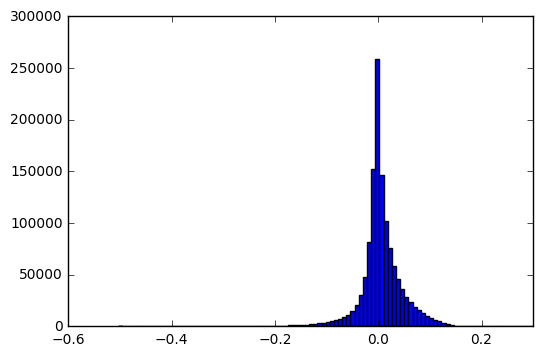

In [305]:
plt.hist(scalars, bins=100)
plt.show()

In [318]:
# we model the code as a zero-centered Laplacian distribution
beta = np.mean(np.abs(scalars))
print beta

# we want to "cut off" at a certain probability
cutoff_p = 0.01
clipval = beta * math.log(1.0 / (2.0 * beta * cutoff_p))

0.0269749
0.202982787391


In [322]:
x = np.linspace(-1.0, 1.0, 200)

x = np.round(x * 16.0).astype('int')
s = set(x)
print np.array(sorted(list(s))) / 16.0 * clipval
print len(s)

[-0.202983 -0.190296 -0.177610 -0.164924 -0.152237 -0.139551 -0.126864
 -0.114178 -0.101491 -0.088805 -0.076119 -0.063432 -0.050746 -0.038059
 -0.025373 -0.012686 0.000000 0.012686 0.025373 0.038059 0.050746 0.063432
 0.076119 0.088805 0.101491 0.114178 0.126864 0.139551 0.152237 0.164924
 0.177610 0.190296 0.202983]
33


In [323]:
[rate, data] = sciwav.read("./SA1.WAV")
processedWave, wparams = preprocessWaveform(data)
windows = extractWindows(processedWave, STEP_SIZE, OVERLAP_SIZE)

transformed, tparams = preprocessWindows(windows)

transformed = np.reshape(transformed, (transformed.shape[0], WINDOW_SIZE, 1))
embed = aac_enc.predict(transformed, batch_size = BATCH_SIZE, verbose = 1)

112/112 [==============================] - 0s


In [324]:
r = np.clip(embed, -clipval, clipval)
r = r / clipval
r = np.round(r * 16.0) / 16.0
r = r * clipval

print embed[0]
print r[0]

autoencOutput = aac_dec.predict(r, batch_size = BATCH_SIZE, verbose = 1)
print autoencOutput.shape
autoencOutput = np.reshape(autoencOutput, (autoencOutput.shape[0], WINDOW_SIZE))

print autoencOutput.shape
recons = unpreprocessWindows(autoencOutput, tparams)

wav = reconstructFromWindows(recons, OVERLAP_SIZE, OVERLAP_FUNC)
wav = unpreprocessWaveform(wav, wparams)

sciwav.write("tst_output_reg.wav", rate, wav.astype(np.int16))

idx = 45

[0.027550 0.027873 0.018470 0.004683 0.010108 0.017071 0.030624 0.089289
 0.047530 0.042331 0.023023 0.010664 0.025311 0.024715 0.014613 0.034672
 0.036772 0.009722 -0.012701 0.028977 0.044850 0.009954 0.035082 0.037520
 0.041404 0.039259 0.012839 0.039504 0.034187 0.030872 0.042880 0.007132
 0.013992 0.020762 0.004329 0.024389 0.016941 0.034748 0.037562 0.042275
 0.021197 0.001990 0.020891 0.025046 0.017392 0.025063 0.042658 0.034171
 0.023575 0.006082 0.033465 0.037905 0.025188 0.031877 0.029405 0.009219
 0.006763 0.009305 0.021811 0.013534 0.023061 0.025335 0.012631 0.019037
 0.010121 -0.006449 0.025745 0.027975 0.031157 0.017920 0.022020 0.021651
 0.022787 0.029960 0.031593 0.028830 0.015962 0.025774 0.019685 0.014462
 0.012405 0.012537 0.029675 0.006206 -0.019854 0.006510 0.008313 0.019259
 0.008915 0.007336 0.002990 0.008133 0.019240 0.011899 0.003375 0.000958
 0.006855 0.010411 0.006873 -0.004086 0.008285 0.007520 0.006569 0.008294
 0.016877 0.027424 0.022403 0.016365 0.016074 0

In [325]:
b = np.linspace(-clipval, clipval, 33)
print b

h = np.histogram(scalars, bins = b, density = True)
print h[0]
print h[1]
h = h[0]
h = h / h.sum()
print h

entropy = 0
for i in h:
    if (i < 1e-4): continue
    entropy += i * math.log(i, 2)
entropy = -entropy
print entropy

[-0.202983 -0.190296 -0.177610 -0.164924 -0.152237 -0.139551 -0.126864
 -0.114178 -0.101491 -0.088805 -0.076119 -0.063432 -0.050746 -0.038059
 -0.025373 -0.012686 0.000000 0.012686 0.025373 0.038059 0.050746 0.063432
 0.076119 0.088805 0.101491 0.114178 0.126864 0.139551 0.152237 0.164924
 0.177610 0.190296 0.202983]
[0.060147 0.073918 0.094296 0.117947 0.156913 0.191309 0.259051 0.332968
 0.422015 0.558426 0.787404 1.130253 1.837934 3.356547 7.350439 20.893339
 14.823828 8.463401 5.545172 3.797150 2.646025 1.906850 1.380473 0.989766
 0.710522 0.464563 0.237746 0.121590 0.057615 0.031802 0.016797 0.008213]
[-0.202983 -0.190296 -0.177610 -0.164924 -0.152237 -0.139551 -0.126864
 -0.114178 -0.101491 -0.088805 -0.076119 -0.063432 -0.050746 -0.038059
 -0.025373 -0.012686 0.000000 0.012686 0.025373 0.038059 0.050746 0.063432
 0.076119 0.088805 0.101491 0.114178 0.126864 0.139551 0.152237 0.164924
 0.177610 0.190296 0.202983]
[0.000763 0.000938 0.001196 0.001496 0.001991 0.002427 0.003286 0.0

-3.1588649245e-05
0.0256761508959


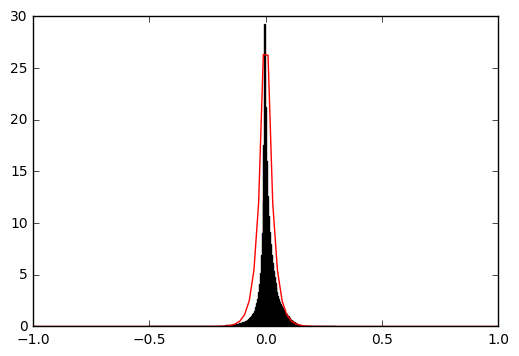

In [309]:
from scipy.stats import laplace

param = laplace.fit(scalars[:10000])
plt.hist(scalars, bins=200, normed = 1)

x = np.linspace(-1.0, 1.0, num = 100)
pdf_fitted = laplace.pdf(x, param[0], param[1])
plt.plot(x, pdf_fitted * 2.0,'r-')

print param[0]
print param[1]

plt.show()